In [ ]:
# This is my parent OOP to start developing Iterative Backtests for the 4 strategies that I have already produced
# It accounts for initial value invested and trading costs by considering the bid-ask spread, allowing for a much more accurate 
# analysis of the performance of each strategy. It allows to track and measure NAV and the fluctuations in the balance. 
# It has commands allowing to buy and sell instruments and to fully exit all position, while considering the costs
# In the future I would like to implement some risk controls into this OOP, such as limiting the amount of capital that is 
# used per trade, warning signs if balances/NAV start falling below a certain level, being able to identify max draw down.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
class IterativeBase():

    def __init__(self,symbol,start,end,amount, use_spread = True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.use_spread = use_spread
        self.get_data()

    def get_data(self):
        raw = pd.read_csv("detailed.csv", parse_dates = ["time"],index_col = "time")
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.price/raw.price.shift(1))
        self.data = raw

    def plot_data(self, cols = None):
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12,8), title = self.symbol)

    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        spread = round(self.data.spread.iloc[bar], 5)
        return date,price,spread

    def print_current_balance(self, bar):
        date, price, spread = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 5)))

    def buy_instrument(self, bar, units = None, amount = None):
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price += spread/2
        if amount is not None:
            units = int(amount/price)
        self.current_balance -= units*price
        self.units += units
        self.trades += 1
        print("{} | Buying {} for {}".format(date,units,round(price, 5)))

    def sell_instrument(self, bar, units = None, amount = None):
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price -= spread/2
        if amount is not None:
            units = int(amount/price)
        self.current_balance += units*price
        self.units -= units
        self.trades += 1
        print("{} | Selling {} for {}".format(date,units,round(price, 5)))

    def print_current_position_value(self, bar):
        date, price, spread = self.get_values(bar)
        cpv = self.units*price
        print("{} | Current Position Value = {}".format(date, round(cpv, 4)))

    def print_current_NAV(self, bar):
        date, price, spread = self.get_values(bar)
        nav = self.current_balance + self.units*price
        print("{} | Net Asset Value = {}".format(date, round(nav, 5)))

    def close_pos(self,bar):
        date, price, spread = self.get_values(bar)
        print(75 * "-")
        print("{} | +++CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.units * price
        self.current_balance -= (abs(self.units)*spread/2*self.use_spread)
        print("{} | closing position of {} for {}".format(date, self.units, price))
        self.units = 0
        self.trades +=1
        perf = (self.current_balance - self.initial_balance)/self.initial_balance * 100
        print("{} | net performance(%) = {}".format(date, round(perf, 4)))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")
    

In [100]:
bc = IterativeBase("EURUSD", "2006-12-31", "2020-06-30", 100000)

In [29]:
bc.data

,price,spread,returns
time,,,
2006-12-31 22:00:00+00:00,1.31985,0.00100,NaN
2007-01-01 22:00:00+00:00,1.32734,0.00015,0.005659
2007-01-02 22:00:00+00:00,1.31688,0.00015,-0.007912
2007-01-03 22:00:00+00:00,1.30845,0.00015,-0.006422
2007-01-04 22:00:00+00:00,1.30025,0.00100,-0.006287
...,...,...,...
2020-06-23 21:00:00+00:00,1.12507,0.00030,-0.005151
2020-06-24 21:00:00+00:00,1.12180,0.00023,-0.002911
2020-06-25 21:00:00+00:00,1.12184,0.00041,0.000036


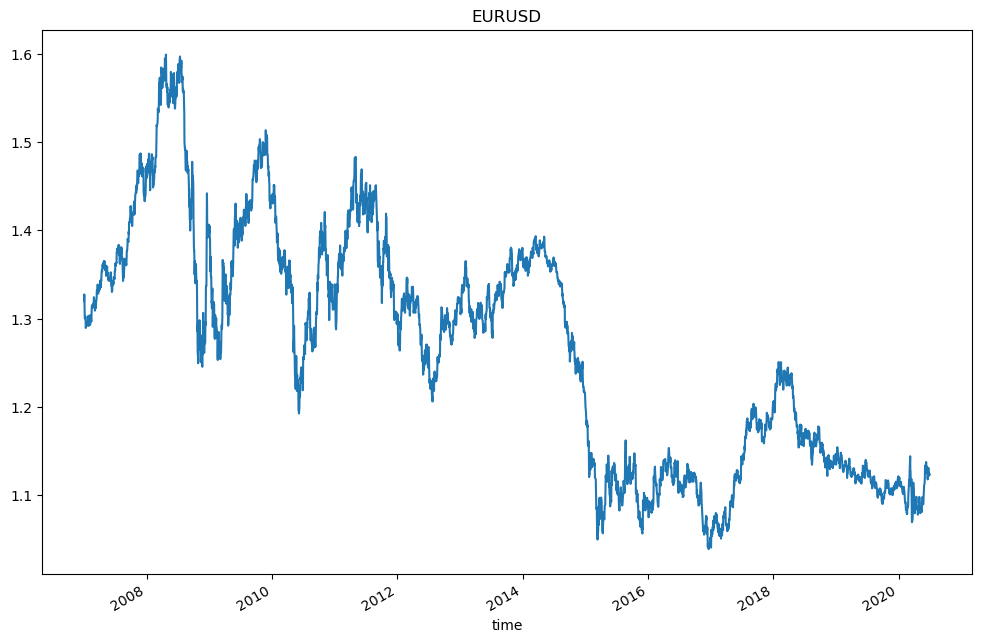

In [30]:
bc.plot_data()

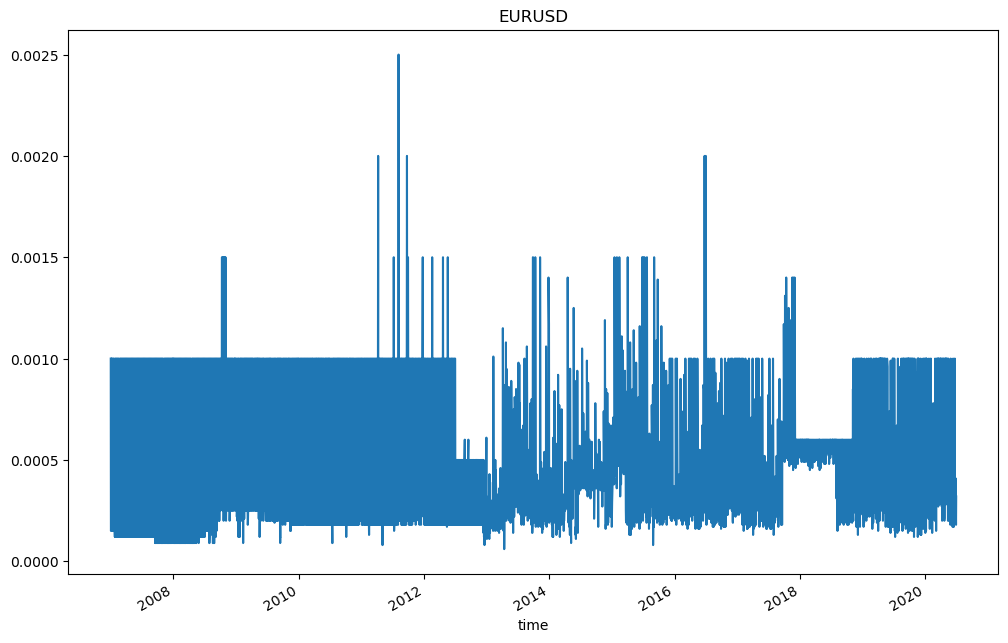

In [31]:
bc.plot_data(cols = "spread")

In [32]:
bc.get_values(-1)

('2020-06-29', 1.12331, 0.00032)

In [69]:
bc.print_current_balance(0)

2006-12-31 | Current Balance: 100000


In [101]:
bc.buy_instrument(0, units = 10000)

2006-12-31 | Buying 10000 for 1.32035


In [91]:
bc.units

10000

In [92]:
bc.print_current_balance(0)

2006-12-31 | Current Balance: 86801.5


In [93]:
bc.buy_instrument(1, amount = 1000)

2007-01-01 | Buying 753 for 1.32734


In [94]:
bc.print_current_balance(1)

2007-01-01 | Current Balance: 85802.01298


In [75]:
bc.print_current_NAV(1)

2007-01-01 | Net Asset Value = 100074.9


In [95]:
bc.sell_instrument(5, units = 2000)

2007-01-06 | Selling 2000 for 1.30166


In [96]:
bc.print_current_NAV(5)

2007-01-06 | Net Asset Value = 99798.76296


In [97]:
bc.close_pos(-1)

---------------------------------------------------------------------------
2020-06-29 | +++CLOSING FINAL POSITION +++
2020-06-29 | closing position of 8753 for 1.12331
2020-06-29 | net performance(%) = -1.7623
2020-06-29 | number of trasdes executed = 4
---------------------------------------------------------------------------
